In [1]:
import sys

sys.path.insert(0, "/mnt/ivy/thliao/project/ML_oxygen/scripts/")
import shap
import xgboost as xgb
from general_func import *
from load_data import *

shap.initjs()
%pylab inline
from IPython.display import Image

8945
8943
(9328, 10054)
Counter({'aerobic': 3767, 'anaerobic': 1714, 'obligate aerobic': 1627, 'facultative': 953, 'microaerophilic': 726, 'obligate anaerobic': 156})


Populating the interactive namespace from numpy and matplotlib


In [2]:
# each_evalf run_rf(args):
#     # print(len(args))
#     X_train, y_train, X_test, y_test, seed = args
#     return RF_m_multi(X_train, y_train, X_test, y_test, seed)


# def RF_m_multi(X_train, y_train, X_test, y_test, seed=100):
#     # X_train, y_train,X_test, y_test,seed = args
#     rforest = RandomForestClassifier(n_jobs=10, random_state=seed)
#     rforest.fit(X_train, y_train)
#     y_pred = rforest.predict_proba(X_test)
#     y_pred_label = rforest.predict(X_test)
#     acc = metrics.balanced_accuracy_score(y_test, y_pred_label)
#     auc = metrics.roc_auc_score(y_test, y_pred[:, 1])
#     explainer = shap.TreeExplainer(rforest, X_train)
#     shap_values = explainer.shap_values(X_test)
#     t = (
#         np.mean(np.abs(shap_values[1]), 0)
#         / np.mean(np.abs(shap_values[1]), 0).sum()
#         * 100
#     )
#     ko2ratio = dict(zip(X_test.columns, t))
#     imp_ratio = t[np.argsort(t)[-20:]].sum()

#     feas = X_train.columns[np.argsort(np.mean(np.abs(shap_values[1]), 0))]
#     return acc, auc, imp_ratio, ko2ratio
from bin.other_convertor.classify_kos import get_ko_infos

def get_top10(_df):
    # input df should be a df with performance of each KO in different times of evaluation
    ko2top10={}
    for _,col in _df.iloc[:-3,:].abs().iteritems():
        top10 = col.sort_values()[-10:].to_dict()
        for k,v in top10.items():
            if k not in ko2top10:
                ko2top10[k] = (1,[v])
            else:
                ot = ko2top10[k]
                ko2top10[k] = (ot[0]+1,ot[1]+[v])
    top10 = sorted(ko2top10.items(),key=lambda x: (x[1][0],np.mean(x[1][1])),reverse=True)[:10]
    top10 = [_[0] for _ in top10]
    return top10

def get_feas_ranking(r, n):
    ko2ratio_comb = defaultdict(int)
    for _ in r:
        for k, v in _[-1].items():
            ko2ratio_comb[k] += v
    summed_ratio = sum(list(ko2ratio_comb.values()))
    ko2ratio_comb_ratio = {k: v / summed_ratio * 100 for k, v in ko2ratio_comb.items()}
    topN_feas = [
        _[0] for _ in sorted(ko2ratio_comb_ratio.items(), key=lambda x: x[1])[::-1][:n]
    ]
    return topN_feas, ko2ratio_comb_ratio

def each_eval(reduced_data, y_bin, n_splits=5,model_f=GBDT_m,return_shap=False,return_models=False):
    best_feas = {}
    shap_dfs = []
    auc_l = []
    acc_l = []
    ap_l = []
    models = []
    c = 0
    sssp = StratifiedShuffleSplit(n_splits=n_splits)
    for train_index, test_index in sssp.split(reduced_data, y_bin):
        X_train_large, X_test_large = (
            reduced_data.iloc[train_index, :],
            reduced_data.iloc[test_index, :],
        )
        y_train_large, y_test_large = y_bin[train_index], y_bin[test_index]
        pred_l, preds, model, accuracy, auc, AP = model_f(
            X_train_large, y_train_large, X_test_large, y_test_large
        )

        if type(model)==xgb.Booster:
            test_d = xgb.DMatrix(X_test_large, label=y_test_large)
            shap_vals = model.predict(test_d, pred_contribs=True)
            shap_vals = shap_vals[:, :-1]  # the last column is the bias term, needed to be removed
            if return_shap:
                shap_df = pd.DataFrame(shap_vals,index=X_test_large.index,columns=X_test_large.columns)
                shap_dfs.append(shap_df)
                continue
            _ko2shap_sum = dict(
                zip(X_test_large.columns, np.sum(np.abs(shap_vals), axis=0))
            )
            best_feas[c] = _ko2shap_sum
        else:
            best_feas[c] = dict(zip(X_test_large.columns,model.coef_[0]))
        auc_l.append(auc)
        acc_l.append(accuracy)
        ap_l.append(AP)
        c += 1
    if return_shap:
        return shap_dfs
    _df = pd.DataFrame.from_dict(best_feas, orient="columns")
    _df = _df.T
    _df.loc[:, "auc"] = auc_l
    _df.loc[:, "acc"] = acc_l
    _df.loc[:, "AP"] = ap_l
    return _df

# sssp = StratifiedShuffleSplit(n_splits=5)
# for train_index, test_index in tqdm(sssp.split(reduced_data, y_bin)):
#     # print("TRAIN:", train_index, "TEST:", test_index)
#     X_train_large, X_test_large = (
#         reduced_data.iloc[train_index, :],
#         reduced_data.iloc[test_index, :],
#     )
#     y_train_large, y_test_large = y_bin[train_index], y_bin[test_index]
#     break

In [3]:
reduced_data = pd.read_csv(
    "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/keggbin_reduced.tsv",
    sep="\t",
    index_col=0,
)
reduced_pfam = pd.read_csv(
    "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/PFAM_reduced.tsv",
    sep="\t",
    index_col=0,
)

# baseline

In [4]:
from tqdm import trange
odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/baseline_GBDT_pfam"
if not exists(odir):
    os.system(f"mkdir -p {odir}")
for _ in trange(50):
    _df = each_eval(reduced_pfam, y_bin, 5,model_f=GBDT_m)
    with open(f"{odir}/{_}.list", "w") as f1:
        _df.to_csv(f1, sep="\t", index=1)
odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/baseline_LR_pfam"
if not exists(odir):os.system(f"mkdir -p {odir}")
for _ in trange(50):
    _df = each_eval(reduced_pfam, y_bin, 5,model_f=LR_m_ll)
    with open(f"{odir}/{_}.list", "w") as f1:
        _df.to_csv(f1, sep="\t", index=1)        
odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/baseline_SVM_pfam"
if not exists(odir):
    os.system(f"mkdir -p {odir}")
for _ in trange(50):
    _df = each_eval(reduced_pfam, y_bin, 5,model_f=svmlinear_m)
    with open(f"{odir}/{_}.list", "w") as f1:
        _df.to_csv(f1, sep="\t", index=1)            

100%|██████████| 50/50 [25:52<00:00, 31.05s/it]


In [6]:
for m in ['SVM','LR','GBDT']:
    odir = f"/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/baseline_{m}_pfam"
    baseline_auc_l = []
    baseline_acc_l = []
    baseline_ap_l = []
    for _ in range(50):
        _df = pd.read_csv(f"{odir}/{_}.list", sep="\t", index_col=0)
        _df = _df.T
        baseline_auc_l += list(_df.loc["auc", :])
        baseline_acc_l += list(_df.loc["acc", :])
        baseline_ap_l += list(_df.loc["AP", :])
    _df = pd.DataFrame()
    _df.loc[:,'acc'] = baseline_acc_l
    _df.loc[:,'auc'] = baseline_auc_l
    _df.loc[:,'AP'] = baseline_ap_l
    _df.to_csv(join(odir,'summary.tab'),sep='\t',index=1)        

In [ ]:
from tqdm import trange
# odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/baseline_GBDT"
# if not exists(odir):os.system(f"mkdir -p {odir}")
# for _ in trange(50):
#     _df = each_eval(reduced_data, y_bin, 5,model_f=GBDT_m)
#     with open(f"{odir}/{_}.list", "w") as f1:
#         _df.to_csv(f1, sep="\t", index=1)
# odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/baseline_LR"
# if not exists(odir):os.system(f"mkdir -p {odir}")
# for _ in trange(50):
#     _df = each_eval(reduced_data, y_bin, 5,model_f=LR_m_ll)
#     with open(f"{odir}/{_}.list", "w") as f1:
#         _df.to_csv(f1, sep="\t", index=1)        
odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/baseline_SVM"
if not exists(odir):os.system(f"mkdir -p {odir}")
for _ in trange(50):
    _df = each_eval(reduced_data, y_bin, 5,model_f=svmlinear_m)
    with open(f"{odir}/{_}.list", "w") as f1:
        _df.to_csv(f1, sep="\t", index=1)     

  0%|          | 0/50 [00:00<?, ?it/s]

In [40]:
for m in ['SVM',
         # 'LR','GBDT'
         ]:
    odir = f"/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/baseline_{m}"
    baseline_auc_l = []
    baseline_acc_l = []
    baseline_ap_l = []
    for _ in range(50):
        _df = pd.read_csv(f"{odir}/{_}.list", sep="\t", index_col=0)
        _df = _df.T
        baseline_auc_l += list(_df.loc["auc", :])
        baseline_acc_l += list(_df.loc["acc", :])
        baseline_ap_l += list(_df.loc["AP", :])
    _df = pd.DataFrame()
    _df.loc[:,'acc'] = baseline_acc_l
    _df.loc[:,'auc'] = baseline_auc_l
    _df.loc[:,'AP'] = baseline_ap_l
    _df.to_csv(join(odir,'summary.tab'),sep='\t',index=1)

In [4]:
baseline_dfs = {}
for m in ['SVM','LR','GBDT']:
    of = f"/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/baseline_{m}"
    _df = pd.read_csv(of+'/summary.tab',sep='\t',index_col=0)
    baseline_dfs[m] = _df

baseline_dfs_pfam = {}
for m in ['SVM','LR','GBDT']:
    of = f"/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/baseline_{m}_pfam"
    _df = pd.read_csv(of+'/summary.tab',sep='\t',index_col=0)
    baseline_dfs_pfam[m] = _df

In [13]:
baseline_dfs['GBDT']['AP'].mean()

0.9908411626115874

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib_venn import venn2

# my_dpi = 150
# plt.figure(figsize=(580 / my_dpi, 580 / my_dpi), dpi=my_dpi)  # 控制图尺寸的同时，使图高分辨率（高清）显示
# g = venn2(
#     subsets=[set(_df.iloc[0, :20]), set(dropped2kos[20])],  # 绘图数据集
#     # set_labels = ('2specific', '2others'), #设置组名
#     set_colors=("#098154", "#3987bd"),  # 设置圈的颜色，中间颜色不能修改
#     alpha=0.6,  # 透明度
#     normalize_to=1.0,  # venn图占据figure的比例，1.0为占满
# )
# plt.show()

# forward selection based on SHAP values of xgboost model

In [5]:
#from tqdm.notebook import tqdm
import time
#time.time()
def rank_features(odir,X,model_f,num_iteration=50):
    if not exists(odir): os.system(f"mkdir -p {odir}")
    log_file = join(odir,'time.log')
    log_stream = open(log_file,'w')
    topN_feas = []
    for t in tqdm(range(num_iteration),desc='1st loop'):
        _t1 = time.time()
        name_suffix = t*10
        ofile = f"{odir}/top{name_suffix}_feas.tsv"
        if exists(ofile):
            dropped_kos = f"{odir}/dropped_top{name_suffix}_ko.list"
            if name_suffix==0:
                continue
            dropped_kos = [_.split('\t')[0] for _ in open(dropped_kos).read().strip().split('\n') if _.startswith('K') or _.startswith('PF')]
            topN_feas+=dropped_kos
            continue
        RG = set(X.columns).difference(set(topN_feas))
        copy_train = X.reindex(columns=RG)
        dfs = []
        for _ in tqdm(range(50),desc='2nd loop',leave=False):
            _df = each_eval(copy_train, y_bin, 5,model_f=model_f)  # row is each time, col are ko,auc,acc
            _df = _df.T
            dfs.append(_df)
        _df = pd.concat(dfs, axis=1)
        _df.columns = list(range(_df.shape[1]))
        top10_feas = get_top10(_df)
        topN_feas += list(top10_feas)
        _df.to_csv(ofile, sep="\t", index=1)
        with open(f"{odir}/dropped_top{len(topN_feas)}_ko.list", "w") as f1:
            ko2ratio = round(_df.mean(1)[top10_feas] / _df.mean(1).sum() * 100, 4).to_dict()
            f1.write("feas\tsummed importance ratio (%)\n")
            for k, v in ko2ratio.items():
                f1.write(f"{k}\t{v}\n")
        _t2 = time.time()
        log_stream.write(f"{t} use {_t2-_t1} seconds\n")
        log_stream.flush()
    log_stream.close()
# 50 iteration takes ~19h

## repeatedly drop

### GBDT

In [ ]:
odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/forward_selection_GBDT_SHAP_PFAMwithAP/"
rank_features(odir,reduced_pfam,model_f=GBDT_m)

In [34]:
# t = 10
# name_suffix = t*2
# ofile = f"{odir}/top{name_suffix}_feas.tsv"
# _df = pd.read_csv(ofile,sep='\t',index_col=0)
# top10 = get_top10(_df)
# print(top10)

['K00627', 'K02275', 'K07304', 'K00632', 'K00176', 'K21636', 'K05527', 'K21567', 'K00116', 'K00526']


### linearSVM

In [ ]:
odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/forward_selection/LinearSVM_SHAP_KEGG"
rank_features(odir,reduced_data,model_f=svmlinear_m)
evaluate_each_iteration(odir,reduced_data,y_bin,svmlinear_m)

odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/forward_selection/LinearSVM_SHAP_PFAM"
rank_features(odir,reduced_pfam,model_f=svmlinear_m)
evaluate_each_iteration(odir,reduced_pfam,y_bin,svmlinear_m)



### Logistic regression

In [ ]:
odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/forward_selection_LR_SHAP_PFAMwithAP"
rank_features(odir,reduced_pfam,model_f=LR_m_ll)

1st loop:   0%|          | 0/50 [00:00<?, ?it/s]

2nd loop:   0%|          | 0/50 [00:00<?, ?it/s]

2nd loop:   0%|          | 0/50 [00:00<?, ?it/s]

## evaluation

In [24]:
def evaluate_each_iteration(odir,X,y_bin,model_f):
    only2performance = {}
    full2performance = {}
    old_kos = []
    for path in tqdm(sorted(glob(f"{odir}/dropped_top*_ko.list"),
                            key=lambda x: int(x.split("top")[-1].split("_")[0])),
                    desc='1st'):
        name = int(path.split("top")[-1].split("_")[0])
        if name in only2performance:
            continue
    #     print(path)
        top10_ko = [row.split("\t")[0] for row in open(path).read().strip().split("\n")[1:]]
        full_kos = list(set(top10_ko + old_kos))
        copy_train = X.reindex(columns=top10_ko)
        dfs = []
        for _ in tqdm(range(50),desc='2nd',leave=False):
            _df = each_eval(copy_train, y_bin, 5,model_f=model_f)
            _df = _df.T
            dfs.append(_df)
        _df = pd.concat(dfs, axis=1)
        _df.columns = list(range(_df.shape[1]))
        only2performance[name] = _df
        
        _df.to_csv(f"{odir}/{name}_onlydf.tsv", sep="\t", index=1)
        copy_train = X.reindex(columns=full_kos)
        dfs = []
        for _ in tqdm(range(50),desc='3rd',leave=False):
            _df = each_eval(copy_train, y_bin, 5,model_f=model_f)
            _df = _df.T
            dfs.append(_df)
        _df = pd.concat(dfs, axis=1)
        _df.columns = list(range(_df.shape[1]))
        full2performance[name] = _df
        _df.to_csv(f"{odir}/{name}_fulldf.tsv", sep="\t", index=1)
        old_kos = full_kos[::]
    # it takes 6h 41m
def get_each_ACC(odir):
    only2performance = {}
    full2performance = {}
    for p in sorted(
        glob(f"{odir}/*_onlydf.tsv"), key=lambda x: int(x.split("/")[-1].split("_")[0])
    ):
        name = int(p.split("/")[-1].split("_")[0])
        only_df = pd.read_csv(p, sep="\t", index_col=0)
        only2performance[name] = only_df
        p = p.replace("onlydf", "fulldf")
        if not exists(p):continue
        full_df = pd.read_csv(p, sep="\t", index_col=0)
        full2performance[name] = full_df
    return only2performance,full2performance
    # pass

### GBDT

In [ ]:
# from tqdm import trange

# odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/backward_selection_SHAP_GBDT"

# only2performance = {}
# full2performance = {}
# old_kos = []
# for path in tqdm(sorted(glob(f"{odir}/dropped_top*_ko.list"),key=lambda x: int(x.split("top")[-1].split("_")[0]))):
#     name = int(path.split("top")[-1].split("_")[0])
#     if name in only2performance:
#         continue
# #     print(path)
#     top10_ko = [row.split("\t")[0] for row in open(path).read().strip().split("\n")[1:]]
#     full_kos = list(set(top10_ko + old_kos))
#     copy_train = reduced_data.reindex(columns=top10_ko)
#     dfs = []
#     break

In [ ]:
odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/forward_selection_GBDT_SHAP_PFAMwithAP/"
#odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/forward_selection_GBDT_SHAP_latest"
evaluate_each_iteration(odir,reduced_pfam,y_bin,GBDT_m)
only2performance,full2performance = get_each_ACC(odir)

In [234]:
# copy_train = reduced_data.reindex(columns = gbdt120)
# clf = GBDT_m(copy_train,y_bin)

# test_d = xgb.DMatrix(copy_train, label=y_bin)
# shap_vals = clf.predict(test_d, pred_contribs=True)[:, :-1] 
# shap_df = pd.DataFrame(shap_vals,index=copy_train.index,columns=gbdt120)
# shap_df.to_csv("/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/GBDT120_SHAP.tsv",sep='\t',index=1)

In [4]:
# def fix_wrong_df(df):
#     dfs = []
#     idx = -1
#     for _ in range(0, 601, 12):
#         if idx != -1:
#             sub_df = df.iloc[:, idx:_]
#             idx = _
#         else:
#             idx = _
#             continue
#         sub_df.columns = list(range(10)) + ["auc", "acc"]
#         dfs.append(sub_df)
#     new_df = pd.concat(dfs, axis=0)
#     return new_df

odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/backward_selection_SHAP_GBDT"
only2performance,full2performance = get_each_ACC(odir)

### linearSVM

In [ ]:
from tqdm import trange
odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/forward_selection_LinearSVM_PFAM"
evaluate_each_iteration(odir,reduced_pfam,y_bin,svmlinear_m)

In [ ]:
# old_kos = []
# for path in tqdm(sorted(glob(f"{odir}/dropped_top*_ko.list"),key=lambda x: int(x.split("top")[-1].split("_")[0]))):
#     top10_ko = [row.split("\t")[0] for row in open(path).read().strip().split("\n")[1:]]
#     full_kos = list(set(top10_ko + old_kos))
#     old_kos = full_kos[::]
#     name = int(path.split("top")[-1].split("_")[0])
#     if exists(f"{odir}/{name}_onlydf.tsv"):
#         continue
#     copy_train = reduced_data.reindex(columns=top10_ko)
#     dfs = []
#     for _ in range(50):
#         _df = each_eval(copy_train, y_bin, 5,model_f=svmlinear_m)
#         _df = _df.T
#         dfs.append(_df)
#     _df = pd.concat(dfs, axis=1)
#     _df.columns = list(range(_df.shape[1]))
#     _df.to_csv(f"{odir}/{name}_onlydf.tsv", sep="\t", index=1)
#     copy_train = reduced_data.reindex(columns=full_kos)
#     dfs = []
#     for _ in range(50):
#         _df = each_eval(copy_train, y_bin, 5,model_f=svmlinear_m)
#         _df = _df.T
#         dfs.append(_df)
#     _df = pd.concat(dfs, axis=1)
#     _df.columns = list(range(_df.shape[1]))
#     _df.to_csv(f"{odir}/{name}_fulldf.tsv", sep="\t", index=1)
    
    

### Logistic regression

In [17]:
odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/forward_selection_LR_PFAM"
evaluate_each_iteration(odir,reduced_pfam,y_bin,LR_m_ll)

In [17]:
# only2performance = {}
# full2performance = {}
# old_kos = []
# for path in tqdm(sorted(glob(f"{odir}/dropped_top*_ko.list"),key=lambda x: int(x.split("top")[-1].split("_")[0]))):
#     name = int(path.split("top")[-1].split("_")[0])
#     if name in only2performance:
#         continue
# #     print(path)
#     top10_ko = [row.split("\t")[0] for row in open(path).read().strip().split("\n")[1:]]
#     full_kos = list(set(top10_ko + old_kos))
#     copy_train = reduced_data.reindex(columns=top10_ko)
#     dfs = []
#     for _ in range(50):
#         _df = each_eval(copy_train, y_bin, 5,model_f=LR_m_ll)
#         _df = _df.T
#         dfs.append(_df)
#     _df = pd.concat(dfs, axis=1)
#     _df.columns = list(range(_df.shape[1]))
#     only2performance[name] = _df
    
#     _df.to_csv(f"{odir}/{name}_onlydf.tsv", sep="\t", index=1)
#     copy_train = reduced_data.reindex(columns=full_kos)
#     dfs = []
#     for _ in range(50):
#         _df = each_eval(copy_train, y_bin, 5,model_f=LR_m_ll)
#         _df = _df.T
#         dfs.append(_df)
#     _df = pd.concat(dfs, axis=1)
#     _df.columns = list(range(_df.shape[1]))
#     full2performance[name] = _df
#     _df.to_csv(f"{odir}/{name}_fulldf.tsv", sep="\t", index=1)
#     old_kos = full_kos[::]

100%|██████████| 49/49 [1:31:30<00:00, 112.05s/it]


In [65]:

odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/forward_selection_GBDT_trained_withLR/"
only2performance = {}
full2performance = {}
old_kos = []
for path in tqdm(sorted(glob(f"{odir}/dropped_top*_ko.list"),key=lambda x: int(x.split("top")[-1].split("_")[0]))):
    name = int(path.split("top")[-1].split("_")[0])
    if name in only2performance:
        continue
#     print(path)
    top10_ko = [row.split("\t")[0] for row in open(path).read().strip().split("\n")[1:]]
    full_kos = list(set(top10_ko + old_kos))
    copy_train = reduced_data.reindex(columns=top10_ko)
    dfs = []
    for _ in range(50):
        _df = each_eval(copy_train, y_bin, 5,model_f=LR_m_ll)
        _df = _df.T
        dfs.append(_df)
    _df = pd.concat(dfs, axis=1)
    _df.columns = list(range(_df.shape[1]))
    only2performance[name] = _df
    
    _df.to_csv(f"{odir}/{name}_onlydf.tsv", sep="\t", index=1)
    copy_train = reduced_data.reindex(columns=full_kos)
    dfs = []
    for _ in range(50):
        _df = each_eval(copy_train, y_bin, 5,model_f=LR_m_ll)
        _df = _df.T
        dfs.append(_df)
    _df = pd.concat(dfs, axis=1)
    _df.columns = list(range(_df.shape[1]))
    full2performance[name] = _df
    _df.to_csv(f"{odir}/{name}_fulldf.tsv", sep="\t", index=1)
    old_kos = full_kos[::]

100%|██████████| 50/50 [1:10:01<00:00, 84.04s/it] 


## changing curve

In [24]:
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
def vis_selected_performance(odir,ofile,baseline_df,metric='auc'):
    #odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/forward_selection_GBDT_SHAP_latest/"
    only2performance = {}
    full2performance = {}
    # only mean use 10 features. Full mean use 10*t features
    for p in tqdm(sorted(
        glob(f"{odir}/*_onlydf.tsv"), key=lambda x: int(x.split("/")[-1].split("_")[0]))):
        name = int(p.split("/")[-1].split("_")[0])
        only_df = pd.read_csv(p, sep="\t", index_col=0)
        only2performance[name] = only_df
        p = p.replace("onlydf", "fulldf")
        if not exists(p):continue
        full_df = pd.read_csv(p, sep="\t", index_col=0)
        full2performance[name] = full_df
    x = []
    y = []
    y2 = []
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
    for path in sorted(glob(f"{odir}/top*_feas.tsv"), key=lambda x: int(x.split("top")[-1].split("_")[0])):
        _name = int(path.split("top")[-1].split("_")[0])
        df = pd.read_csv(path, sep="\t", index_col=0)
        x.append(_name)
        y.append(df.loc[metric, :].median())
        ko_imp_ratios = df.iloc[:-2,:].abs()/df.iloc[:-2,:].abs().sum(0)*100
        top10_ratio = (
            ko_imp_ratios.median(1).sort_values(ascending=False)[:10].sum()
            / ko_imp_ratios.median(1).sum()
            * 100
        )
        y2.append(top10_ratio)
    
    fig.append_trace(go.Scatter(y=y, x=x, showlegend=True, marker_color="#3557fe",name='Remaining N-t*10 features'), 1, 1)
    fig.append_trace(go.Bar(y=y2, x=x, showlegend=False, marker_color="#004D40"), 2, 1)
    fig.append_trace(
        go.Scatter(
            y=[only2performance[k].T.mean()[metric] for k in x[1:] if k in only2performance],
            x=x[1:],
            showlegend=True,
             mode="lines",
            name = 'Dropped each 10 features',
            marker_color="#FFEE58",
        ),1,1,)

    fig.append_trace(
        go.Scatter(
            y=[full2performance[k].T.mean()[metric] for k in x[1:] if k in full2performance],
            x=x[1:],
            showlegend=True,
             mode="lines",
            name = 'Top t*10 features',
            marker_color="#B71C1C",
        ),1,1,)

    baseline = np.mean(baseline_df[metric])
    u = baseline + np.std(baseline_df[metric])
    l = baseline - np.std(baseline_df[metric])
    fig.append_trace(go.Scatter(x=[0,0,500,500,0], y=[l,u,u,l,l], fill="toself",
                                mode="lines",opacity=0.5,
                               line=dict(color="#000000", width=2, dash="dot"),
                                name='baseline N features',
                                showlegend=False,
                               ),1,1)
    fig.append_trace(go.Scatter(x=[0,500], y=[baseline,baseline],
                                mode="lines",opacity=0.5,
                               line=dict(color="#000000", width=1, ),
                                #name='baseline N features',
                                showlegend=False,
                               ),1,1)
    
#     fig.append_trace(
#         go.Scatter(
#             y=[baseline, baseline],
#             x=[x[0], x[-1]],
#             showlegend=True,
#             mode="lines",
#             marker_color="#000000",
#             name='baseline N features',
#             line=dict(
#                 color="#000000", width=2, dash="dot"
#             ),  # dash options include 'dash', 'dot', and 'dashdot'
#         ),1,1,)
    fig.layout.width = 1300
    fig.layout.height = 500
    #fig.layout.xaxis2.showticklabels = False
    fig.layout.yaxis2.domain = [0, 0.18]
    fig.layout.yaxis1.domain = [0.2, 1]
    fig.layout.template = "simple_white"
    display(Image(fig.to_image()))
    fig.write_image(ofile)#"/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/selected_performance_GBDT.pdf")
    
    bb = np.mean(baseline_df[metric])
    ys = [full2performance[k].T.mean()[metric] for k in x[1:] if k in full2performance]
    print(f'mean {metric}: ')
    print([k for k in zip(x[1:],ys) if k[1]>=bb])
    bb = np.median(baseline_df[metric])
    ys = [full2performance[k].T.median()[metric] for k in x[1:] if k in full2performance]
    print(f'median {metric}: ')
    print([k for k in zip(x[1:],ys) if k[1]>=bb])    

### All combinations

100%|██████████| 50/50 [00:01<00:00, 36.95it/s]


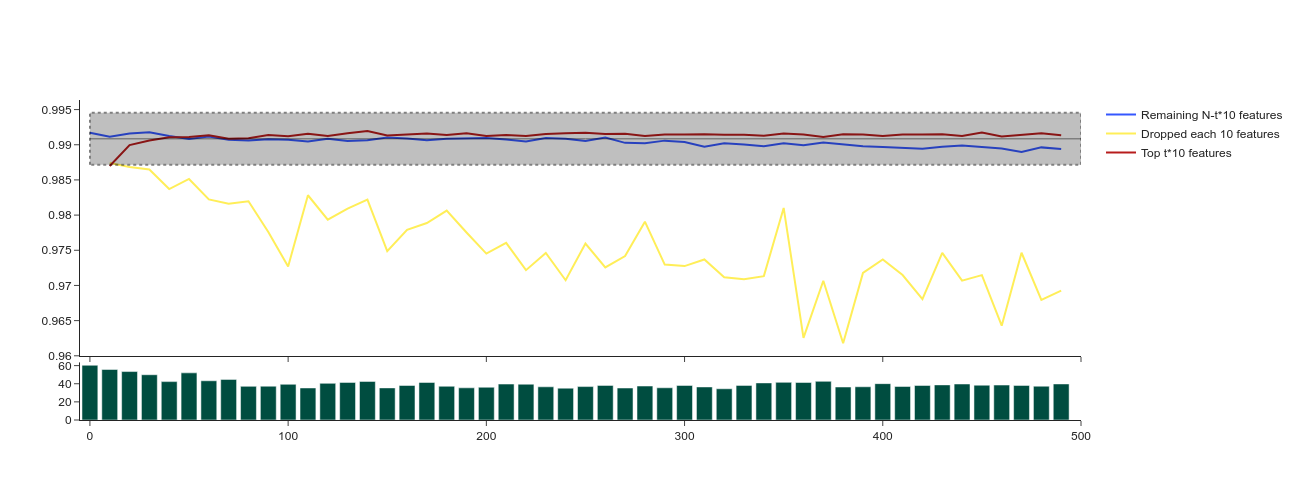

mean AP: 
[(40, 0.991050935408582), (50, 0.9910955013507712), (60, 0.9913383019550102), (70, 0.9908604434944049), (80, 0.9909191196914234), (90, 0.991369554992015), (100, 0.9912203367866204), (110, 0.9915761616699579), (120, 0.9912390468357578), (130, 0.9916211468673155), (140, 0.9919478640098502), (150, 0.9913309696596483), (160, 0.9915069672391293), (170, 0.9915923601873801), (180, 0.9913708045244729), (190, 0.9916501412964661), (200, 0.9912407165221594), (210, 0.9914026386064729), (220, 0.99124568560045), (230, 0.9915219133807716), (240, 0.9916177936088787), (250, 0.9917033126397922), (260, 0.9915335060807267), (270, 0.9915536651084011), (280, 0.9912457634056364), (290, 0.9914545910440157), (300, 0.9914568775630618), (310, 0.9914927957248005), (320, 0.9914050388477315), (330, 0.9914245386627372), (340, 0.991266509724473), (350, 0.9915949321040994), (360, 0.9914543725881658), (370, 0.991108889901182), (380, 0.9914843968093398), (390, 0.9914636360240762), (400, 0.9912311795648225), (4

100%|██████████| 50/50 [00:01<00:00, 28.81it/s]


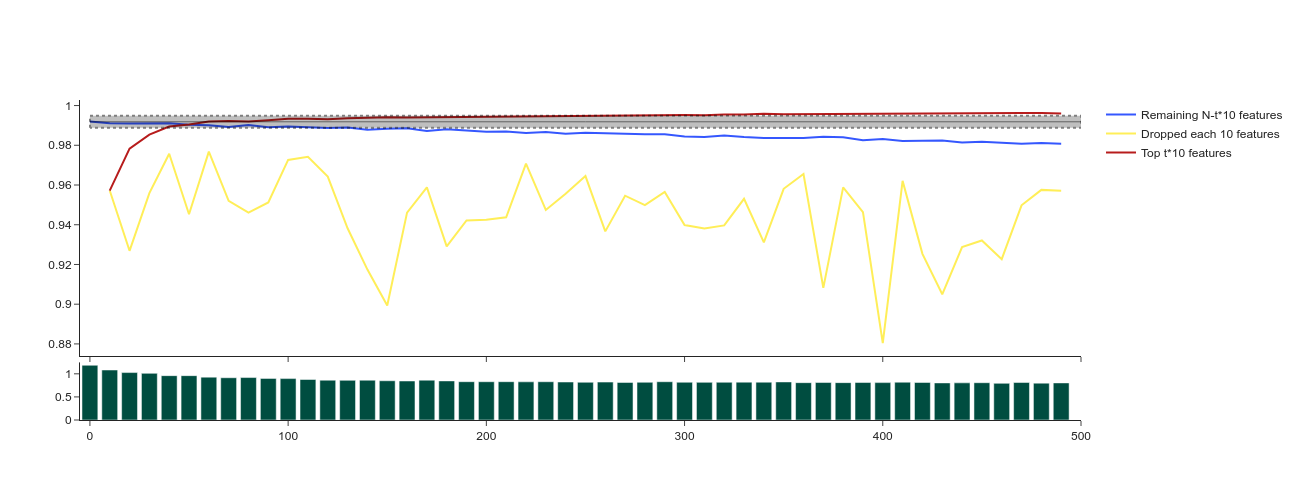

mean AP: 
[(60, 0.9920188956631535), (70, 0.9922655717712674), (80, 0.9920040050489406), (90, 0.9926495243866429), (100, 0.993377012906056), (110, 0.9934005535885512), (120, 0.9930796251326852), (130, 0.9936315254909592), (140, 0.9940243286492831), (150, 0.994106272008657), (160, 0.9940123215695702), (170, 0.9940953299089842), (180, 0.9942745249596704), (190, 0.994322784778674), (200, 0.9944237504782412), (210, 0.9946100060747642), (220, 0.9946132334314849), (230, 0.9946983249073511), (240, 0.9948116486397165), (250, 0.9949845756135102), (260, 0.994944050706878), (270, 0.9952163492330859), (280, 0.9953393764925418), (290, 0.9951009413163627), (300, 0.9952169594976128), (310, 0.9951511502988635), (320, 0.9954915066575499), (330, 0.9954475411746383), (340, 0.9958797077315804), (350, 0.9956436049292409), (360, 0.9957108617454163), (370, 0.9958636318251756), (380, 0.9956850719489642), (390, 0.9960988041580128), (400, 0.9959874809303956), (410, 0.9960222482903368), (420, 0.9961870582771881)

100%|██████████| 50/50 [00:01<00:00, 32.16it/s]


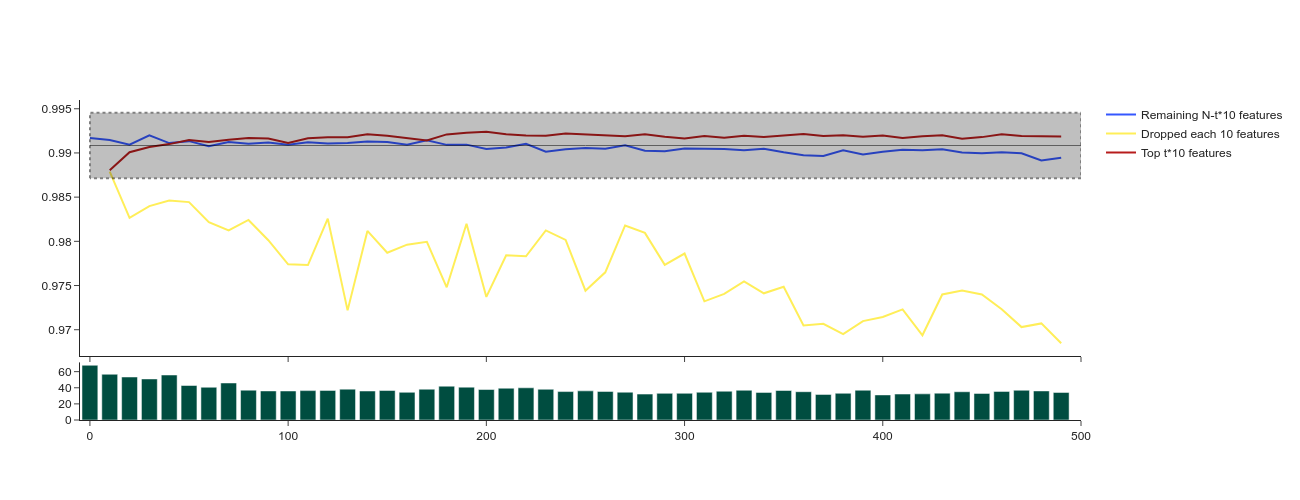

mean AP: 
[(40, 0.9909996919644902), (50, 0.9914597258378238), (60, 0.9912369267998354), (70, 0.9915037411777896), (80, 0.9916799965886784), (90, 0.991631341323306), (100, 0.9911248428778854), (110, 0.9916516197353534), (120, 0.9917676478527657), (130, 0.9917779415453616), (140, 0.9921129866552264), (150, 0.9919361519473471), (160, 0.9916711488329992), (170, 0.9914047439966985), (180, 0.9920978750783885), (190, 0.9922954780394513), (200, 0.9923940058653764), (210, 0.9921224874021654), (220, 0.9919683473878581), (230, 0.9919381582268882), (240, 0.9921988330040256), (250, 0.992086918053193), (260, 0.9919515496165133), (270, 0.9918951999106854), (280, 0.9921274708238814), (290, 0.9918223199900437), (300, 0.9916297944042982), (310, 0.99191238413099), (320, 0.9917064680799441), (330, 0.9919495479034568), (340, 0.9918110971208549), (350, 0.9919464293592344), (360, 0.9921352839579434), (370, 0.9919233048436339), (380, 0.9920108067855331), (390, 0.9918257392726977), (400, 0.9919837479851782), 

100%|██████████| 50/50 [00:01<00:00, 32.87it/s]


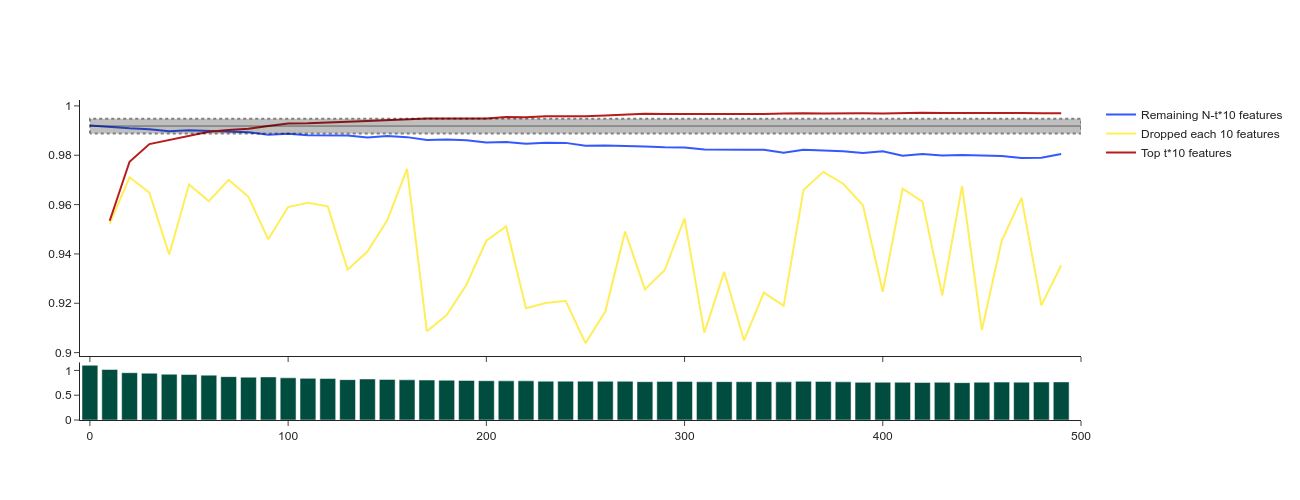

mean AP: 
[(90, 0.9918522087778987), (100, 0.9928338773411092), (110, 0.9929401906109125), (120, 0.9931030758702329), (130, 0.9935431926544093), (140, 0.9938733991299378), (150, 0.9941533491741864), (160, 0.9947160909958214), (170, 0.9948480270177779), (180, 0.9948974571969128), (190, 0.9949166199243434), (200, 0.9948583107478777), (210, 0.9954566582555641), (220, 0.9953853723739889), (230, 0.9957696447638952), (240, 0.9958142750472984), (250, 0.995754996843778), (260, 0.9961480167694973), (270, 0.9964802543933711), (280, 0.9967927792918789), (290, 0.9966953532559993), (300, 0.9966590884033463), (310, 0.9966397781722239), (320, 0.996741340793825), (330, 0.9968494456498441), (340, 0.9966910121629399), (350, 0.9969088835004168), (360, 0.9970475098955477), (370, 0.9968751212028136), (380, 0.9970567375620387), (390, 0.996988535887045), (400, 0.9968987083791654), (410, 0.9970897637555065), (420, 0.9972014689810939), (430, 0.9970842259404663), (440, 0.9971462863716106), (450, 0.9970855514681

In [8]:
for d in ['KEGG','PFAM']:
    for m in ['GBDT','LR']:
        odir = f"/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/forward_selection/{m}_SHAP_{d}"
        _ = vis_selected_performance(odir,
                                 f"/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/selected_performance_AP_{m}_{d}.pdf",
                                 baseline_dfs[m],
                                     metric='AP')
        print(d,m)


In [ ]:
d = '

100%|██████████| 50/50 [00:01<00:00, 33.20it/s]


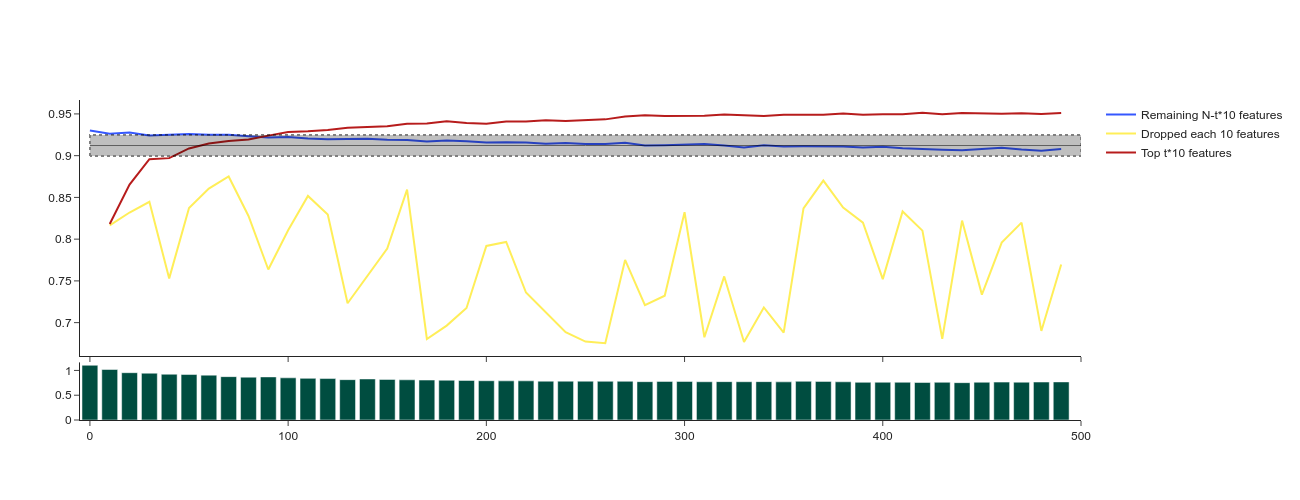

mean acc: 
[(60, 0.9144984591679504), (70, 0.9176875887489051), (80, 0.919363983806157), (90, 0.9239877337683919), (100, 0.9282023021843563), (110, 0.9291341430254692), (120, 0.9306987824405579), (130, 0.9333439378833197), (140, 0.933781821203057), (150, 0.9351092782259276), (160, 0.938249629898185), (170, 0.9385081724523399), (180, 0.9412706124052084), (190, 0.9390215112239042), (200, 0.9381001540832047), (210, 0.9408640140185508), (220, 0.9409112208828062), (230, 0.9424944560258613), (240, 0.9416427082389197), (250, 0.9423868243753587), (260, 0.9434743798906312), (270, 0.9469204809812993), (280, 0.9483035590199091), (290, 0.947363802531799), (300, 0.9475051965316177), (310, 0.9478733043294365), (320, 0.9492370011178581), (330, 0.9484375207710205), (340, 0.9476228284842445), (350, 0.9490079911779817), (360, 0.9493836973926706), (370, 0.9490512855373275), (380, 0.9506141877398109), (390, 0.9491061814556325), (400, 0.9494776579352848), (410, 0.9495167980905768), (420, 0.9513424272636636

100%|██████████| 50/50 [00:01<00:00, 32.16it/s]


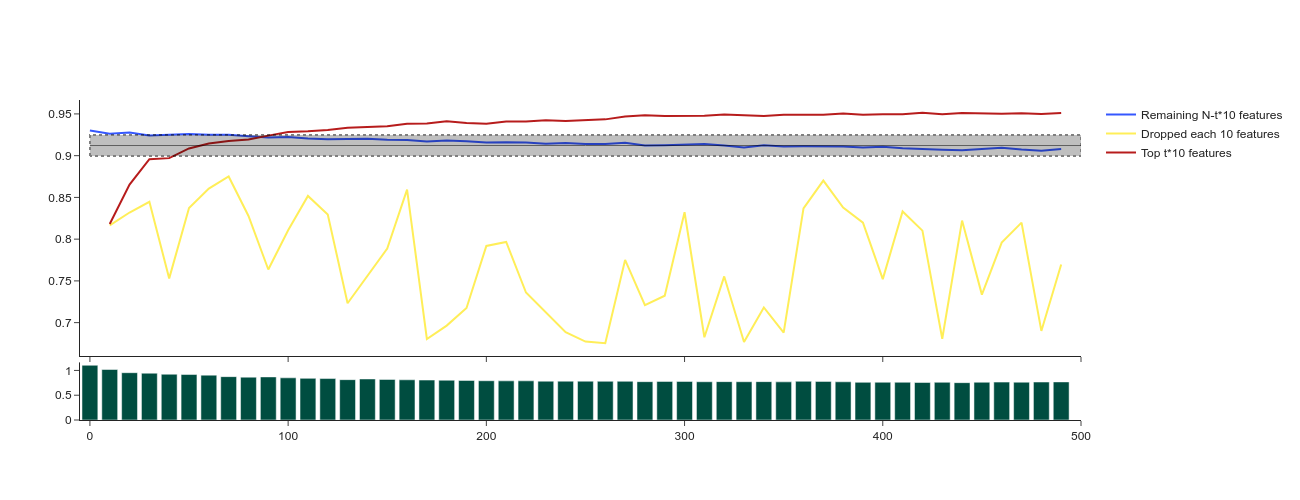

mean acc: 
[(60, 0.9144984591679504), (70, 0.9176875887489051), (80, 0.919363983806157), (90, 0.9239877337683919), (100, 0.9282023021843563), (110, 0.9291341430254692), (120, 0.9306987824405579), (130, 0.9333439378833197), (140, 0.933781821203057), (150, 0.9351092782259276), (160, 0.938249629898185), (170, 0.9385081724523399), (180, 0.9412706124052084), (190, 0.9390215112239042), (200, 0.9381001540832047), (210, 0.9408640140185508), (220, 0.9409112208828062), (230, 0.9424944560258613), (240, 0.9416427082389197), (250, 0.9423868243753587), (260, 0.9434743798906312), (270, 0.9469204809812993), (280, 0.9483035590199091), (290, 0.947363802531799), (300, 0.9475051965316177), (310, 0.9478733043294365), (320, 0.9492370011178581), (330, 0.9484375207710205), (340, 0.9476228284842445), (350, 0.9490079911779817), (360, 0.9493836973926706), (370, 0.9490512855373275), (380, 0.9506141877398109), (390, 0.9491061814556325), (400, 0.9494776579352848), (410, 0.9495167980905768), (420, 0.9513424272636636

In [9]:
for d in ['KEGG','PFAM']:
    for m in ['SVM']:        
        _ = vis_selected_performance(odir,
                                 f"/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/selected_performance_ACC_{m}_{d}.pdf",
                                 baseline_dfs[m],
                                     metric='acc')
        print(d,m)

## distribution

In [23]:
import plotly.figure_factory as ff
#_f = ff.create_distplot([list(c.keys())], ['a'], bin_size=[1])

target_X = reduced_pfam
for f in glob('/mnt/storage3/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/selected_performance_*_PFAM_*.kos'):
    target_genes = open(f).read().strip().split('\n')
    

    fig = go.Figure()
    x1 = target_X.loc[y_bin==1,target_genes].sum(1)
    c = {k:v/len(x1)*100 for k,v in Counter(x1).items()}
    data = sorted(c.items())
    x,y = [_[0] for _ in data],[_[1] for _ in data]
    fig.add_bar(x=x,y=y,name='aerobe',marker={'color':"#f9f871"},)
    fig.add_scatter(x=x,y=y,name='aerobe',mode='lines',showlegend=False,marker={'color':"#f9f871"},)
    x1 = target_X.loc[y_bin==0,target_genes].sum(1)
    c = {k:v/len(x1)*100 for k,v in Counter(x1).items()}
    data = sorted(c.items())
    x,y = [_[0] for _ in data],[_[1] for _ in data]
    fig.add_scatter(x=x,y=y,name='anaerobe',mode='lines',showlegend=False,marker={'color':"#845ec2"},)
    fig.add_bar(x=x,y=y,name='anaerobe',marker={'color':"#845ec2"})

    # _f = ff.create_distplot([list(c.keys())], ['a'], bin_size=[1])
    # fig.add_scatter(x=_f.data[1]['x'],y=_f.data[1]['y'],name='anaerobe',mode='lines',showlegend=False,marker={'color':"#845ec2"},)

    fig.update_layout(barmode='overlay', height=400,width=600,template='simple_white')
    fig.update_layout(xaxis_range=[0,len(target_genes)])
    fig.layout.xaxis.title = 'Bin of the total number of presence of each gene in XXX'
    fig.layout.yaxis.title = 'Ratio of genomes'
    #display(Image(fig.to_image()))
    fig.write_image(f.replace('.kos','')+'_geneDist.pdf',)
    
target_X = reduced_data
for f in glob('/mnt/storage3/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/selected_performance_*_KEGG_*.kos'):
    target_genes = open(f).read().strip().split('\n')
    fig = go.Figure()
    x1 = target_X.loc[y_bin==1,target_genes].sum(1)
    c = {k:v/len(x1)*100 for k,v in Counter(x1).items()}
    data = sorted(c.items())
    x,y = [_[0] for _ in data],[_[1] for _ in data]
    fig.add_bar(x=x,y=y,name='aerobe',marker={'color':"#f9f871"},)
    fig.add_scatter(x=x,y=y,name='aerobe',mode='lines',showlegend=False,marker={'color':"#f9f871"},)
    x1 = target_X.loc[y_bin==0,target_genes].sum(1)
    c = {k:v/len(x1)*100 for k,v in Counter(x1).items()}
    data = sorted(c.items())
    x,y = [_[0] for _ in data],[_[1] for _ in data]
    fig.add_scatter(x=x,y=y,name='anaerobe',mode='lines',showlegend=False,marker={'color':"#845ec2"},)
    fig.add_bar(x=x,y=y,name='anaerobe',marker={'color':"#845ec2"})

    # _f = ff.create_distplot([list(c.keys())], ['a'], bin_size=[1])
    # fig.add_scatter(x=_f.data[1]['x'],y=_f.data[1]['y'],name='anaerobe',mode='lines',showlegend=False,marker={'color':"#845ec2"},)

    fig.update_layout(barmode='overlay', height=400,width=600,template='simple_white')
    fig.update_layout(xaxis_range=[0,len(target_genes)])
    fig.layout.xaxis.title = 'Bin of the total number of presence of each gene in XXX'
    fig.layout.yaxis.title = 'Ratio of genomes'
    #display(Image(fig.to_image()))
    fig.write_image(f.replace('.kos','')+'_geneDist.pdf',)

In [14]:
from bin.other_convertor.classify_kos import *
dfs = []
for f in glob('/mnt/storage3/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/selected_performance_*_KEGG_*.kos'):
    n = f.split('/')[-1]
    model = n.split('_')[-3]  # top50
    db = n.split('_')[-2]
    numkos = int(n.split('_')[-1].replace('.kos','').replace('top',''))
    odir = f"/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/forward_selection/{model}_SHAP_{db}"
    name = model+f'_top{numkos}'
    a = pd.read_csv(f'{odir}/top0_feas.tsv',sep='\t',index_col=0)
    target_genes = open(f).read().strip().split('\n')
    target_genes = list(a.loc[target_genes,:].sum(1).sort_values().index)
    importances = a.loc[target_genes,:].sum(1).to_dict()
    info_kos = get_ko_infos(target_genes)
    # br_kos = ko_classified_br(target_genes)
    # infos = get_br_info(br_kos)
    # sig_kos_df = pd.concat(infos, axis=0)
    sig_kos_df = pd.DataFrame(index=target_genes)
    sig_kos_df.loc[:,'group'] = name
    sig_kos_df.loc[:, 'importances'] = [importances.get(_, 0) for _ in sig_kos_df.index] 

    # ratio in aerobe and anaerobe
    x1 = reduced_data.loc[y_bin==1,target_genes].sum(0).to_dict()
    num_org = reduced_data.loc[y_bin==1,:].shape[0]
    c = {k:round(v/num_org*100,2)
         for k,v in x1.items()}
    sig_kos_df.loc[:,'presence ratio in aerobe/%'] = [c[k] for k in sig_kos_df.index]
    x1 = reduced_data.loc[y_bin==0,target_genes].sum(0).to_dict()
    num_org = reduced_data.loc[y_bin==0,:].shape[0]
    c = {k:round(v/num_org*100,2)
         for k,v in x1.items()}
    sig_kos_df.loc[:,'presence ratio in anaerobe/%'] = [c[k] for k in sig_kos_df.index]
    
    sig_kos_df.loc[:, 'des'] = [info_kos.get(_, '') for _ in sig_kos_df.index] 
    dfs.append(sig_kos_df)
merged_df = pd.concat(dfs,axis=0)
merged_df.to_excel('/mnt/storage3/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/selected_kos.siminfo.xlsx')

In [23]:
d = pd.DataFrame(index = set(merged_df.index))
for i,row in merged_df.iterrows():
    d.loc[i,row['group']] = 'Yes'
    d.loc[i,'presence ratio in aerobe/%'] = row['presence ratio in aerobe/%']
    d.loc[i,'presence ratio in anaerobe/%'] = row['presence ratio in anaerobe/%']
    d.loc[i,'des'] = row['des']
    d.loc[i,'importances'] = row['importances']
d = d.fillna('')
d.loc[:,'gene'] = [ko2genename[_] for _ in d.index]
d.to_excel('/mnt/storage3/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/selected_kos.geneinfo.xlsx')

In [20]:
ko2info = pd.read_csv('/home-user/thliao/db/protein_db/kegg/v20230301/link/ko2name.list',sep='\t',index_col=0)
ko2genename = ko2info['gene'].to_dict()

## which part of variation is larger, either each repeat or each fold

In [36]:

def get_performance(odir):
    only2performance = {}
    full2performance = {}
    for p in sorted(glob(f"{odir}/*_onlydf.tsv"), key=lambda x: int(x.split("/")[-1].split("_")[0])):
        name = int(p.split("/")[-1].split("_")[0])
        only_df = pd.read_csv(p, sep="\t", index_col=0)
        only2performance[name] = only_df
        p = p.replace("onlydf", "fulldf")
        if not exists(p):continue
        full_df = pd.read_csv(p, sep="\t", index_col=0)
        full2performance[name] = full_df
    return only2performance,full2performance


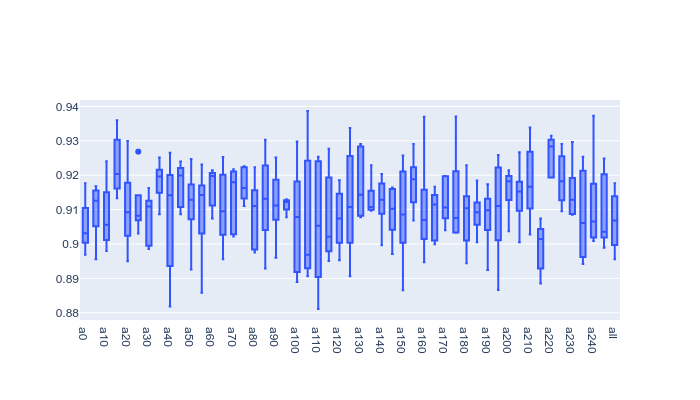

In [37]:
odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/forward_selection_GBDT"
only2performance,full2performance = get_performance(odir)

fig = go.Figure()
for idx in zip(range(0,250,5),
               range(5,251,5)):
    acc_list = list(full2performance[10].loc['acc',[str(_) for _ in list(range(idx[0],idx[1]))] ])
    fig.add_box(x=['a'+str(idx[0])]*5,
                y=acc_list,marker={'color':'#3254ff'},
                showlegend=False)
fig.add_box(x=['all']*full2performance[10].shape[0],
            y= list(full2performance[10].loc['acc',:]),
            marker={'color':'#3254ff'},showlegend=False)
fig.layout.height = 400
fig.layout.width = 700
display(Image(fig.to_image()))

# backward selection based on SHAP values of RF model

In [ ]:
# take 4 h
topN_feas = []
for t in tqdm(range(50)):
    gs = set(X_train_large.columns).difference(set(topN_feas))
    copy_train, copy_test = X_train_large.reindex(columns=gs), X_test_large.reindex(columns=gs)
    params = []
    for _ in range(20):
        params.append([copy_train, y_train_large, copy_test, y_test_large, _])
    with mp.Pool(processes=4) as tp:
        r = list(tqdm(tp.imap(run_rf, params), total=len(params)))
    # record
    record_df = pd.DataFrame(
        [_[:-1] for _ in r],
        columns=["balanced accuracy", "AUC", "Importatnce Ratios of top20 feas"],
    )
    num_removed_feas = len(topN_feas)
    record_df.to_csv(
        f"/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/backward_selection/dropped_top{num_removed_feas}.csv",
        index=False)
    _topN_feas, ko2ratio_comb_ratio = get_feas_ranking(r, 20)
    with open(
        f"/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/backward_selection/dropped_top{num_removed_feas}_ko_ranking.list",        "w") as f1:
        f1.write("feas\tsummed importance ratio (%)\n")
        for k, v in ko2ratio_comb_ratio.items():
            f1.write(f"{k}\t{v}\n")
    topN_feas += _topN_feas

## read the dropped and retained KOS

In [7]:
dropped2kos_full = {}
dropped2kos = {}
pre_kos = []

for dropped_ko in tqdm(
    sorted(
        glob(
            f"/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/backward_selection/dropped_top*_ko_ranking.list"
        ),
        key=lambda x: int(x.split("/")[-1].split("top")[-1].split("_")[0]),
    )
):
    num_dropped = int(dropped_ko.split("/")[-1].split("top")[-1].split("_")[0])
    if num_dropped == 0:
        continue
    else:
        _df = pd.read_csv(dropped_ko, sep="\t", index_col=0)
        _df = _df.sort_values("summed importance ratio (%)", ascending=False)

    missing_ko = reduced_data.columns.difference(set(_df.index))
    dropped2kos_full[num_dropped] = list(missing_ko)
    if not pre_kos:
        pre_kos = list(missing_ko)
    else:
        missing_ko = list(set(missing_ko).difference(pre_kos))
        pre_kos += missing_ko
    dropped2kos[num_dropped] = list(missing_ko)

100%|██████████| 50/50 [00:00<00:00, 68.38it/s]


## evaluate the performance of model using the dropped kos

In [114]:
useonly2performance = defaultdict(lambda: defaultdict(list))
sssp = StratifiedShuffleSplit(n_splits=5)
for train_index, test_index in sssp.split(reduced_data, y_bin):
    X_train_large, X_test_large = (
        reduced_data.iloc[train_index, :],
        reduced_data.iloc[test_index, :],
    )
    y_train_large, y_test_large = y_bin[train_index], y_bin[test_index]

    for num_dropped, missing_ko in tqdm(dropped2kos.items()):
        copy_train, copy_test = (
            X_train_large.reindex(columns=missing_ko),
            X_test_large.reindex(columns=missing_ko),
        )

        rforest = RandomForestClassifier(n_jobs=10, class_weight="balanced_subsample")
        rforest.fit(copy_train, y_train_large)
        y_pred = rforest.predict_proba(copy_test)
        y_pred_label = rforest.predict(copy_test)
        acc = metrics.balanced_accuracy_score(y_test_large, y_pred_label)
        auc = metrics.roc_auc_score(y_test_large, y_pred[:, 1])
        useonly2performance[num_dropped]["auc"].append(auc)
        useonly2performance[num_dropped]["acc"].append(acc)

median_useonly2performance = {
    k: {_k: np.mean(_v) for _k, _v in v.items()} for k, v in useonly2performance.items()
}
onlydf = pd.DataFrame.from_dict(median_useonly2performance).T

100%|██████████| 49/49 [00:33<00:00,  1.44it/s]


In [115]:
usefull2performance = defaultdict(lambda: defaultdict(list))
sssp = StratifiedShuffleSplit(n_splits=5)
for train_index, test_index in sssp.split(reduced_data, y_bin):
    X_train_large, X_test_large = (
        reduced_data.iloc[train_index, :],
        reduced_data.iloc[test_index, :],
    )
    y_train_large, y_test_large = y_bin[train_index], y_bin[test_index]

    for num_dropped, missing_ko in tqdm(dropped2kos_full.items()):
        copy_train, copy_test = (
            X_train_large.reindex(columns=missing_ko),
            X_test_large.reindex(columns=missing_ko),
        )

        rforest = RandomForestClassifier(n_jobs=10, class_weight="balanced_subsample")
        rforest.fit(copy_train, y_train_large)
        y_pred = rforest.predict_proba(copy_test)
        y_pred_label = rforest.predict(copy_test)
        acc = metrics.balanced_accuracy_score(y_test_large, y_pred_label)
        auc = metrics.roc_auc_score(y_test_large, y_pred[:, 1])
        usefull2performance[num_dropped]["auc"].append(auc)
        usefull2performance[num_dropped]["acc"].append(acc)
        
        
median_usefull2performance = {
    k: {_k: np.mean(_v) for _k, _v in v.items()} for k, v in usefull2performance.items()
}
fulldf = pd.DataFrame.from_dict(median_usefull2performance).T

100%|██████████| 49/49 [00:39<00:00,  1.25it/s]


## accumulated important ratios

In [ ]:
fig = go.Figure()
fig.add_scatter(x=list(range(cum_df.shape[0])), y=cum_df["summed importance ratio (%)"])
fig.layout.title.text = "Cummulative SHAP values in RandomForest"
fig.layout.xaxis.title.text = "number of genes"
fig.layout.yaxis.title.text = "cumulative SHAP values (%)"
fig.layout.width = 500
fig.layout.height = 500
fig.show()